In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import itertools
import os
import time
from pathlib import Path
from tqdm.notebook import tqdm
import math
import pickle
from scipy import ndimage
import random
# pytorch stuff
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tifffile import imsave
# need for AMP
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

torch.manual_seed(3)
from tqdm.notebook import tqdm

#https://github.com/mcordts/cityscapesScripts

In [3]:
PATH = Path('/home/jott2/brainlabs/2D_Files/data')

In [4]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [5]:
the_list=list((PATH/"input/").iterdir())[50000:55000] 

In [6]:
the_list[10]

PosixPath('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI137S0481_ses-M36_T1wX57X.tif')

In [7]:
data=pd.read_pickle('ALL_DATA.pkl')

In [8]:
data['filenames']

0       sub-ADNI100S0006_ses-M06_T1w
1       sub-ADNI100S0006_ses-M12_T1w
2       sub-ADNI100S0006_ses-M18_T1w
3       sub-ADNI100S0006_ses-M36_T1w
4       sub-ADNI100S0015_ses-M12_T1w
                    ...             
1638    sub-ADNI068S4431_ses-M84_T1w
1639    sub-ADNI018S2133_ses-M96_T1w
1640    sub-ADNI116S4855_ses-M72_T1w
1641    sub-ADNI011S4278_ses-M84_T1w
1642    sub-ADNI051S5285_ses-M48_T1w
Name: filenames, Length: 1643, dtype: object

In [9]:
import matplotlib.pyplot as plt
import skimage.io as skio


def show(num=100,cond='sagittal',file_name=' ' ,df=None,info=False):
    print(f'{cond} brain slice slide {num}' ) 
    f, axarr = plt.subplots(1,2)
    f.set_figheight(10)
    f.set_figwidth(10)
    axarr[0].title.set_text('Input')
    axarr[1].title.set_text('Segmentation')
    if(cond=='sagittal'):
        img = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}{num}XX.tif')
        axarr[0].imshow(img)
        img1 = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_seg{num}XX.tif')
        axarr[1].imshow(img1)
        print(img.shape)
        plt.show()
    if(cond=='coronal'):
        img = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}X{num}X.tif')
        axarr[0].imshow(img)
        img1 = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_segX{num}X.tif')
        axarr[1].imshow(img1)
        print(img.shape)
        plt.show()
    if(cond=='horizontal'):
        img = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}XX{num}.tif')
        axarr[0].imshow(img)
        img1 = skio.imread(f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_segXX{num}.tif')
        axarr[1].imshow(img1)
        print(img.shape)
    plt.show()
    print()
    if info:
        print(df[df['filenames']==file_name].T)
    return(img,img1)
        


sagittal brain slice slide 150
(218, 182)


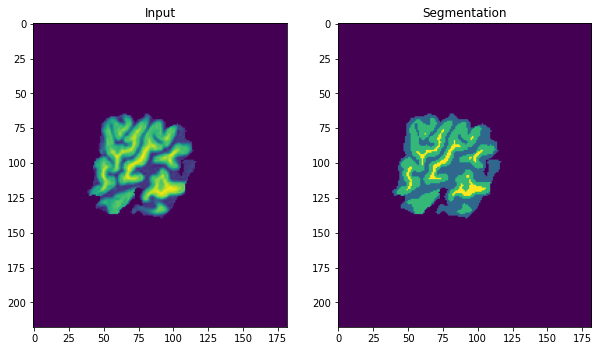


coronal brain slice slide 30
(182, 182)


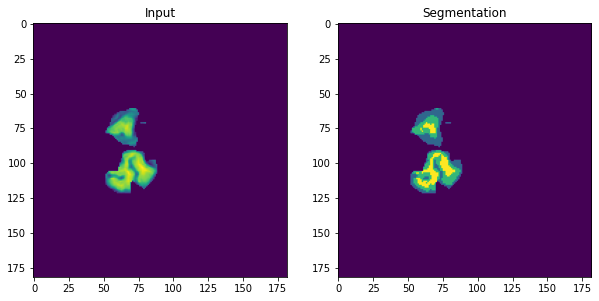


horizontal brain slice slide 100
(182, 218)


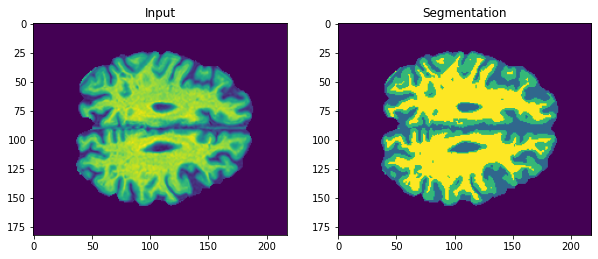


                                                                       2
AGE                                                                 80.4
PTEDUCAT                                                              13
APOE4                                                                  0
ADAS11                                                             11.33
MMSE                                                                  24
Ventricles_bl                                                      40165
Hippocampus_bl                                                      5542
WholeBrain_bl                                                     957221
Entorhinal_bl                                                       2480
Fusiform_bl                                                        18458
MidTemp_bl                                                         18689
ICV_bl                                                           1514260
MOCA_bl                                           

In [17]:
files=data['filenames'][2]
si,st=show(150,cond='sagittal',file_name=files,df=data)
ci,ct=show(30,cond='coronal',file_name=files,df=data)
hi,ht=show(100,cond='horizontal',file_name=files,df=data,info=True)

# Grabbing test data

In [18]:
#Creates a list of grouped input and target file paths for test train split
def getdataset(df, slices_per_patient, random_seed=True):
    if random_seed:
        random.seed(3)
    if(slices_per_patient > 120):
        print('Please add slices between 1 and 121 ')
        return 
    Picture_data=[]
    inpu=''
    targ=''
    for record in range(len(df)):
        file_name=df['filenames'][record]
        index_pos_sag=range(30,150)
        index_pos_cor=range(30,180)
        index_pos_hor=range(30,150)
        index_pos_sag=random.sample(index_pos_sag,slices_per_patient)
        index_pos_cor=random.sample(index_pos_cor,slices_per_patient)
        index_pos_hor=random.sample(index_pos_hor,slices_per_patient)
        for i in range(slices_per_patient):
            X=random.randint(0,3)
            num=0
            if(X==0):
                num=index_pos_sag[i]
                inpu=f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}{num}XX.tif'
                targ=f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_seg{num}XX.tif'
            if(X==1):
                num=index_pos_cor[i]
                inpu=f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}X{num}X.tif'
                targ=f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_segX{num}X.tif'
            if(X==2):
                num=index_pos_hor[i]
                inpu=f'/home/jott2/brainlabs/2D_Files/data/input/{file_name}XX{num}.tif'
                targ=f'/home/jott2/brainlabs/2D_Files/data/target/{file_name}_segXX{num}.tif'
            Picture_data.append((inpu,targ,file_name))
    return list(set(Picture_data))

In [19]:
MODEL_DATA=getdataset(data,3)

[('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI036S2378_ses-M60_T1wX104X.tif',
  '/home/jott2/brainlabs/2D_Files/data/target/sub-ADNI036S2378_ses-M60_T1w_segX104X.tif',
  'sub-ADNI036S2378_ses-M60_T1w'),
 ('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI068S4274_ses-M12_T1w148XX.tif',
  '/home/jott2/brainlabs/2D_Files/data/target/sub-ADNI068S4274_ses-M12_T1w_seg148XX.tif',
  'sub-ADNI068S4274_ses-M12_T1w'),
 ('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI011S4366_ses-M12_T1wXX84.tif',
  '/home/jott2/brainlabs/2D_Files/data/target/sub-ADNI011S4366_ses-M12_T1w_segXX84.tif',
  'sub-ADNI011S4366_ses-M12_T1w'),
 ('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI027S4802_ses-M12_T1w140XX.tif',
  '/home/jott2/brainlabs/2D_Files/data/target/sub-ADNI027S4802_ses-M12_T1w_seg140XX.tif',
  'sub-ADNI027S4802_ses-M12_T1w'),
 ('/home/jott2/brainlabs/2D_Files/data/input/sub-ADNI021S0647_ses-M06_T1wX163X.tif',
  '/home/jott2/brainlabs/2D_Files/data/target/sub-ADNI021S0647_ses-M06_T1w_se

## Resizing images  ACTUALLY CROPPED IN NEXT SECTION FOR FINAL MODEL
Note that this should be done before training and not `during` training. 

In [20]:
si.shape

(218, 182)

In [21]:
ci.shape

(182, 182)

In [22]:
def resize_image(img, img_h=218, img_w=218):
    img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_NEAREST) # (shape: (512, 1024, 3))
    return img

In [23]:
x = resize_image(si, img_h=218, img_w=218)
y = resize_image(ci, img_h=218, img_w=218)

In [24]:
x.shape, y.shape

((218, 218), (218, 218))

In [25]:
def plot_two_imgs(im1, im2):
    f = plt.figure(figsize=(12,8))
    f.add_subplot(1,2, 1)
    plt.imshow(im1)
    f.add_subplot(1,2, 2)
    plt.imshow(im2)

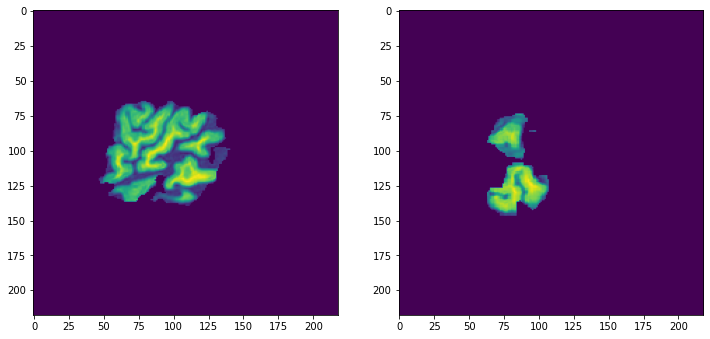

In [26]:
plot_two_imgs(x, y)

# With direction of Daren Ma i am going to crop all images to be 182 by 182 and create a seperate train test folder for this

In [36]:
X=[]
Y=[]
for i in MODEL_DATA:
    X.append(i[0])
    Y.append(i[1])
    

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [53]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

2305
988
824


(182, 218)


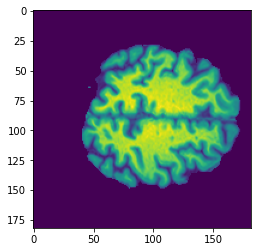

(218, 182)


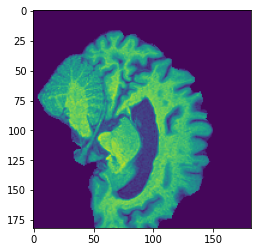

(182, 182)


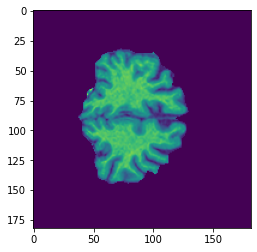

(182, 182)


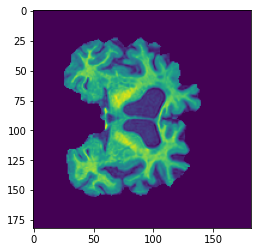

(182, 218)


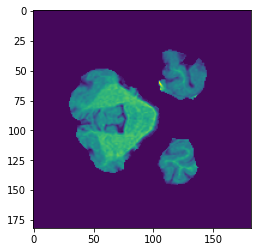

(182, 182)


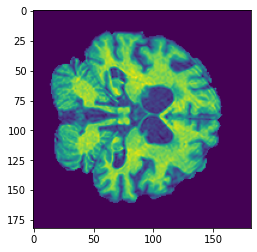

(182, 218)


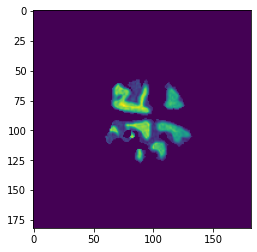

(182, 182)


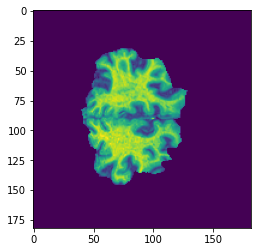

(218, 182)


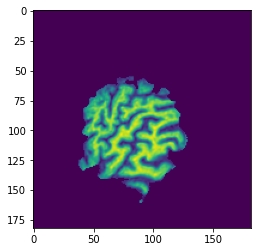

(218, 182)


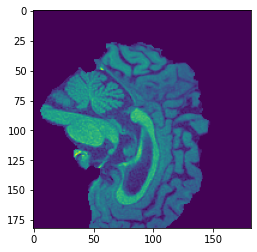

In [44]:

    img = skio.imread(i)
    print(img.shape)
    crop_img = img[0:182, 0:182]
    plt.imshow(crop_img)
    plt.show()

# Here is where I Adding my data to the folder will make into function later

In [59]:
#ADD FILES
#for i in range(len(X_train)):
#    namex=X_train[i].split('/')[-1]
#    namey=y_train[i].split('/')[-1]
#    imgx = skio.imread(X_train[i])
#    imgy = skio.imread(y_train[i])
#    crop_imgx = imgx[0:182, 0:182]
#    crop_imgy = imgy[0:182, 0:182]
#    imsave(f'/home/jott2/brainlabs/2D_Files/train/{namex}',crop_imgx)
#    imsave(f'/home/jott2/brainlabs/2D_Files/train/{namey}',crop_imgy)
  

In [62]:
  
#for i in range(len(X_val)):
#    namex=X_val[i].split('/')[-1]
#    namey=y_val[i].split('/')[-1]
#    imgx = skio.imread(X_val[i])
#    imgy = skio.imread(y_val[i])
#    crop_imgx = imgx[0:182, 0:182]
#    crop_imgy = imgy[0:182, 0:182]
#    imsave(f'/home/jott2/brainlabs/2D_Files/val/{namex}',crop_imgx)
#    imsave(f'/home/jott2/brainlabs/2D_Files/val/{namey}',crop_imgy)
 

In [63]:
   
#for i in range(len(X_test)):
#    namex=X_test[i].split('/')[-1]
#    namey=y_test[i].split('/')[-1]
#    imgx = skio.imread(X_test[i])
#    imgy = skio.imread(y_test[i])
#    crop_imgx = imgx[0:182, 0:182]
#    crop_imgy = imgy[0:182, 0:182]
#    imsave(f'/home/jott2/brainlabs/2D_Files/test/{namex}',crop_imgx)
#    imsave(f'/home/jott2/brainlabs/2D_Files/test/{namey}',crop_imgy)

# Stop here 

In [17]:
def resize_all_imgs(old_folder, new_folder, img_h=218, img_w=218):
    files = [f for f in old_folder.rglob("*.png")]
    for path in files:
        im = read_image(path)
        im2 = resize_image(im, img_h=img_h, img_w=img_w)
        new_path = new_folder/path.name
        cv2.imwrite(str(new_path), im2)

In [18]:
def create_img_dirs(img_h=266, img_w=532):
    imgs_dir = PATH/"imgs_{1}_{2}".format(PATH,img_h, img_w)
    for folder in ["train", "val", "test"]:
        (imgs_dir/folder).mkdir(parents=True, exist_ok=True)
        print(imgs_dir/folder)
        resize_all_imgs(PATH/"leftImg8bit"/folder, imgs_dir/folder, img_h=266, img_w=532)
    
    (imgs_dir/"labels").mkdir(parents=True, exist_ok=True)
    resize_all_imgs(PATH/"meta", imgs_dir/"labels")  

In [19]:
#create_img_dirs()

## albumentations for data augmentation 

See other tranformations here: <br>
`https://albumentations.ai/docs/api_reference/augmentations/transforms/` <br>
`https://github.com/albumentations-team/albumentations`

In [20]:
crop = (512, 256)
transformImg = A.Compose([A.RandomCrop(width=crop[0],height=crop[1]),
                          A.HorizontalFlip(p=.5),
                          A.VerticalFlip(p=.5),
                          A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
                          A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75)])          

In [21]:
centercrop = A.CenterCrop(width=crop[0],height=crop[1])

In [22]:
path = PATH/"imgs_266_532/train/zurich_000051_000019_leftImg8bit.png"
x = read_image(path)
path = PATH/"imgs_266_532/labels/zurich_000051_000019.png"
y = read_image(path)

In [23]:
transformed = transformImg(image=x, mask=y[:,:,0]) 
img = transformed['image']
mask = transformed['mask']

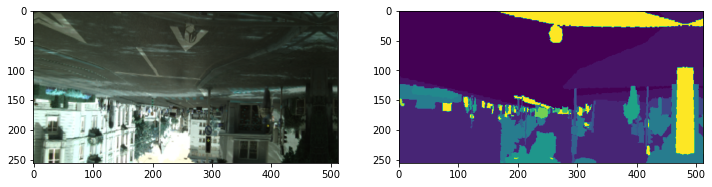

In [27]:
plot_two_imgs(img, mask)

In [24]:
transformed = centercrop(image=x, mask=y) 
img = transformed['image']
mask = transformed['mask']

(<matplotlib.image.AxesImage at 0x7fe6d3a1af40>, (256, 512, 3))

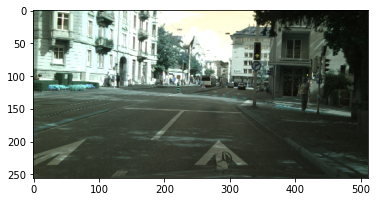

In [25]:
plt.imshow(img), img.shape

## Dataset

In [26]:
class CityScapesDataset(Dataset):
    def __init__(self, data_path, folder, transform=True, crop = (512, 256)):
        """data_path = PATH/"imgs_266_532"
           folder is in [val, train, test]
           trasform should be True for train
        """
        self.transform = transform
        self.imgs_files = [f for f in (data_path/folder).glob('*.png')]
        self.label_names = [(f.name).split("_leftImg8bit.png")[0] + ".png" for f in self.imgs_files]
        self.labels_files = [data_path/"labels"/f for f in self.label_names] 
        
        self.train_transforms = A.Compose([
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, border_mode = cv2.BORDER_REFLECT, value = 0.0, p = .75),
            A.GridDistortion(border_mode=cv2.BORDER_REFLECT, value=0.0, p=0.75),
            A.RandomCrop(width=crop[0],height=crop[1])]) 
        
        self.val_transforms = A.CenterCrop(width=crop[0],height=crop[1])
        
    def __getitem__(self, index):
        im_path = self.imgs_files[index]
        label_path = self.labels_files[index]
        im = read_image(im_path)
        label = read_image(label_path)
        
        if self.transform:
            transformed = self.train_transforms(image=im, mask=label[:,:,0])
        else:
            transformed = self.val_transforms(image=im, mask=label[:,:,0])
        
        x = transformed['image']/255.
        y = transformed['mask']
        return np.rollaxis(x, 2), y
            
        
    def __len__(self):
        return len(self.imgs_files)

In [27]:
ds_train = CityScapesDataset(PATH/"imgs_266_532/", "train")
ds_val = CityScapesDataset(PATH/"imgs_266_532/", "val",  transform=False)

In [28]:
x, y = ds_train[0]
x.shape, y.shape

((3, 256, 512), (256, 512))

In [29]:
x, y = ds_val[0]
x.shape, y.shape

((3, 256, 512), (256, 512))

In [30]:
len(ds_train), len(ds_val)

(2975, 500)

In [31]:
dl_train = DataLoader(ds_train, batch_size=3, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=3, shuffle=False, num_workers=1)

## Basic UNet model

In [32]:
# basic unet with batch normalization
#look at the shapes line by line 
f_size = 7
padding = (int((f_size-1)/2),int((f_size-1)/2))
chs = [32, 64, 128, 256, 512] #, 1024]

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, f_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, f_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class unet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        # pooling
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # ENCODER
        self.conv00 = ConvBlock(3, 32)
        self.conv10 = ConvBlock(32, 64)
        self.conv20 = ConvBlock(64, 128)
        self.conv30 = ConvBlock(128, 256)
        self.conv40 = ConvBlock(256, 512)
        
        # DECODER
        self.upconv31 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv31 = ConvBlock(2*256, 256)
        self.upconv22 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv22 = ConvBlock(2*128, 128)
        self.upconv13 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv13 = ConvBlock(2*64, 64)
        self.upconv04 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv04 = ConvBlock(2*32, 32)
        
        # final layers
        self.final04 = nn.Conv2d(32, 20, 1)
         
    def forward(self, x):
        
        # Encoder Path
        x00 = self.conv00(x)
        x10 = self.conv10(self.pool(x00))
        x20 = self.conv20(self.pool(x10))
        x30 = self.conv30(self.pool(x20))
        x40 = self.conv40(self.pool(x30))
        
        # Up-sampling 
        x31 = self.upconv31(x40)
        x31 = self.conv31(torch.cat((x30,x31), dim=1)) #This could cause an issue with hte shapes
        x22 = self.upconv22(x31)
        x22 = self.conv22(torch.cat((x20,x22),dim=1))
        x13 = self.upconv13(x22)
        x13 = self.conv13(torch.cat((x10,x13),dim=1))
        x04 = self.upconv04(x13)
        x04 = self.conv04(torch.cat((x00,x04),dim=1))
        
        # Outputs
        x04 = self.final04(x04)
        
        return x04
    
model = unet().cuda()

In [33]:
x, y = next(iter(dl_train))

In [34]:
y_hat = model(x.float().cuda())
y_hat.shape #matching batch size, 

torch.Size([3, 20, 256, 512])

In [35]:
with open(PATH/"meta/class_weights.pkl", "rb") as file: # (needed for python3)
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = class_weights.type(torch.FloatTensor).cuda()

In [36]:
class_weights, class_weights.sum()

(tensor([ 3.3621, 14.0315,  4.9867, 39.2544, 36.5126, 32.8962, 46.2867, 40.6904,
          6.6982, 33.5555, 18.4878, 32.9743, 47.6765, 12.7003, 45.2054, 45.7837,
         45.8253, 48.4061, 42.7559,  7.9122], device='cuda:0'),
 tensor(606.0019, device='cuda:0'))

In [37]:
F.cross_entropy(y_hat, y.long().cuda(), weight=class_weights)

tensor(3.1397, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [38]:
x.shape, y.shape, y_hat.shape

(torch.Size([3, 3, 256, 512]),
 torch.Size([3, 256, 512]),
 torch.Size([3, 20, 256, 512]))

## computing accuracy

In [39]:
y_hat.shape

torch.Size([3, 20, 256, 512])

In [40]:
y = y.float().cuda()
y.shape

torch.Size([3, 256, 512])

In [41]:
pred = torch.max(y_hat, 1)[1]
pred.shape

torch.Size([3, 256, 512])

In [42]:
pred[0]

tensor([[ 5, 11,  8,  ...,  5, 18,  8],
        [10, 17, 17,  ...,  6, 17,  5],
        [17, 10, 18,  ...,  8, 17,  6],
        ...,
        [10, 10, 10,  ..., 13,  5,  5],
        [17, 17, 10,  ..., 16, 18, 11],
        [17, 17,  5,  ..., 16, 16, 16]], device='cuda:0')

In [43]:
correct = (pred == y).sum()
correct.shape

torch.Size([])

In [44]:
# why this formula?
accuracy = correct/(256*512*3)
accuracy

tensor(0.0152, device='cuda:0')

## training

In [45]:
def valid_metrics(model, dl_valid, pretrained=False):
    model.eval()
    batch_losses = []
    total = 0
    correct = 0
    for x, y in dl_valid:
        with torch.no_grad(): # reduces memory comsumption
            total += y.size(0)
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            if pretrained:
                y_hat = y_hat["out"]
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            pred = torch.max(y_hat, 1)[1]
            correct += (pred == y).float().sum().item()
            
    total *= y.size(1)*y.size(2) 
    return np.mean(batch_losses), correct/total

In [46]:
def train_epochs(model, optimizer, dl_train, dl_valid, epochs, pretrained=False):
    batch_losses = []
    
    pbar = tqdm(total=epochs*len(dl_train))
    for epoch in range(epochs):
        best_val_loss, _ = valid_metrics(model, dl_valid, pretrained)
        model.train()
        for x, y in dl_train:
            x = x.float().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            if pretrained:
                y_hat = y_hat["out"]
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            pbar.update()
        train_loss = np.mean(batch_losses)
        val_loss, val_acc = valid_metrics(model, dl_valid, pretrained)
        print ("train loss: %.3f val loss: %.3f val acc: %.3f" % (train_loss, val_loss, val_acc)) 
        
        # save the model weights to disk:
        if val_loss < best_val_loss:
            path = "{0}/models/model_{1:.0f}.pth".format(PATH, 100*val_acc)
            print(path)
            torch.save(model.state_dict(), path)
            best_val_loss = val_loss

In [47]:
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=1)

In [48]:
model = unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
train_epochs(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/1860 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Making predictions

In [49]:
def load_model(m, p): m.load_state_dict(torch.load(p))

In [50]:
model = unet().cuda()
path = "/home/jott2/brainlabs/data/models/model_79.pth"
load_model(model, path)

In [51]:
ds_val.imgs_files[10], ds_val.labels_files[10]

(PosixPath('/home/jott2/brainlabs/data/imgs_266_532/val/frankfurt_000001_010156_leftImg8bit.png'),
 PosixPath('/home/jott2/brainlabs/data/imgs_266_532/labels/frankfurt_000001_010156.png'))

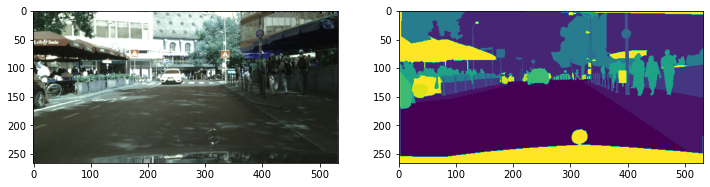

In [52]:
img = read_image(ds_val.imgs_files[10])
mask = read_image(ds_val.labels_files[10])
plot_two_imgs(img, mask[:,:,0])

In [53]:
x, y = ds_val[10]

In [54]:
x.shape

(3, 256, 512)

In [55]:
x1 = x[None,]
x1.shape

(1, 3, 256, 512)

In [56]:
y_hat = model(torch.FloatTensor(x1).cuda())
y_hat.shape

torch.Size([1, 20, 256, 512])

In [57]:
pred = torch.max(y_hat, 1)[1]
pred.shape

torch.Size([1, 256, 512])

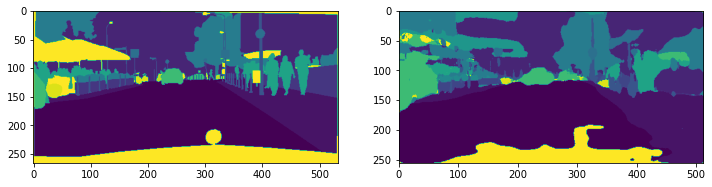

In [58]:
plot_two_imgs(mask[:,:,0], pred[0].cpu().numpy())

## Training with half precision
Here is the a tick to increase batch size and train faster.

In [12]:
from apex import amp

In [60]:
def valid_metrics_half(model, dl_valid):
    model.eval()
    batch_losses = []
    total = 0
    correct = 0
    for x, y in dl_valid:
        with torch.no_grad(): # reduces memory comsumption
            total += y.size(0)
            x = x.half().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            pred = torch.max(y_hat, 1)[1]
            correct += (pred == y).float().sum().item()
            
    total *= y.size(1)*y.size(2) 
    return np.mean(batch_losses), correct/total

In [61]:
def train_epochs_half(model, optimizer, dl_train, dl_valid, epochs):
    batch_losses = []
    
    pbar = tqdm(total=epochs*len(dl_train))
    for epoch in range(epochs):
        best_val_loss, _ = valid_metrics_half(model, dl_valid)
        model.train()
        for x, y in dl_train:
            x = x.half().cuda()
            y = y.long().cuda()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y, weight=class_weights)
            batch_losses.append(loss.item())
            
            optimizer.zero_grad() 
            #loss.backward()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            pbar.update()
            
        train_loss = np.mean(batch_losses)
        val_loss, val_acc = valid_metrics_half(model, dl_valid)
        print ("train loss: %.3f val loss: %.3f val acc: %.3f" % (train_loss, val_loss, val_acc)) 
        
        # save the model weights to disk:
        if val_loss < best_val_loss:
            path = "{0}/models/model_half_{1:.0f}.pth".format(PATH, 100*val_acc)
            print(path)
            torch.save(model.state_dict(), path)
            best_val_loss = val_loss

In [62]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=1)

In [63]:
model = unet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                  keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [65]:
train_epochs_half(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/930 [00:00<?, ?it/s]

train loss: 2.089 val loss: 2.058 val acc: 0.721
/home/jott2/brainlabs/data/models/model_half_72.pth
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train loss: 2.005 val loss: 1.934 val acc: 0.722
/home/jott2/brainlabs/data/models/model_half_72.pth
train loss: 1.932 val loss: 1.854 val acc: 0.708
/home/jott2/brainlabs/data/models/model_half_71.pth
train loss: 1.868 val loss: 1.733 val acc: 0.746
/home/jott2/brainlabs/data/models/model_half_75.pth
train loss: 1.808 val loss: 1.674 val acc: 0.736
/home/jott2/brainlabs/data/models/model_half_74.pth
train loss: 1.754 val loss: 1.525 val acc: 0.789
/home/jott2/brainlabs/data/models/model_half_79.pth
train loss: 1.703 val loss: 1.453 val acc: 0.770
/home/jott2/brainlabs/data/models/model_half_77.pth
train loss: 1.658 val loss: 1.393 val acc: 0.787
/home/jott2/brainlabs/data/models/model_half_79.pth
train loss: 1.616 val loss: 1.328 val acc: 0.786
/home/jott2/brainlabs/data/models/model_half_79.pth
train loss:

In [66]:
train_epochs_half(model, optimizer, dl_train, dl_val, epochs=10)

  0%|          | 0/930 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Segmentation from pretrained models

In [67]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [68]:
model = createDeepLabv3(outputchannels=20)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/jott2/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [69]:
model = model.cuda()

In [70]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True, num_workers=1)
dl_val = DataLoader(ds_val, batch_size=10, shuffle=False, num_workers=1)

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [72]:
x, y = next(iter(dl_train))

In [73]:
x = x.float().cuda()
y_hat = model(x)

In [74]:
y_hat.keys()

odict_keys(['out', 'aux'])

In [75]:
y_hat['out'].shape

torch.Size([10, 20, 256, 512])

In [81]:
import gc
gc.collect()

2932

In [82]:
torch.cuda.empty_cache()

In [83]:
train_epochs(model, optimizer, dl_train, dl_val, epochs=10, pretrained=True)

  0%|          | 0/2980 [00:00<?, ?it/s]

train loss: 1.166 val loss: 0.857 val acc: 0.811
/home/jott2/brainlabs/data/models/model_81.pth
train loss: 0.992 val loss: 0.751 val acc: 0.829
/home/jott2/brainlabs/data/models/model_83.pth
train loss: 0.903 val loss: 0.740 val acc: 0.808
/home/jott2/brainlabs/data/models/model_81.pth
train loss: 0.844 val loss: 0.692 val acc: 0.825
/home/jott2/brainlabs/data/models/model_83.pth
train loss: 0.801 val loss: 0.654 val acc: 0.845
/home/jott2/brainlabs/data/models/model_84.pth
train loss: 0.766 val loss: 0.655 val acc: 0.832
train loss: 0.739 val loss: 0.629 val acc: 0.845
/home/jott2/brainlabs/data/models/model_84.pth
train loss: 0.716 val loss: 0.671 val acc: 0.834
train loss: 0.698 val loss: 0.608 val acc: 0.854
/home/jott2/brainlabs/data/models/model_85.pth
train loss: 0.679 val loss: 0.598 val acc: 0.846
/home/jott2/brainlabs/data/models/model_85.pth


[autoreload of six failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of numpy.core.overrides failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-p

[autoreload of pandas.core.dtypes.common failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/common.py", line 64, in <module>
    _NS_DTYPE = conversion.NS_DTYPE
AttributeError: module 

[autoreload of pandas.core.arrays.sparse failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/sparse/__init__.py", line 4, in <module>
    from pandas.core.arrays.sparse.array import (
I

[autoreload of pandas.core.window.common failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/pandas/core/window/common.py", line 13, in <module>
    from pandas.core.groupby.base import GroupByMixin
Impor

[autoreload of pandas.core.reshape.merge failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py", line 46, in <module>
    from pandas.core.arrays.categorical import _recode_for_

[autoreload of pandas.io.html failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: read_html() requires a code object with 5 free vars, not 0
]
[autoreload of pandas.io.json._json failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  F

[autoreload of scipy.stats._continuous_distns failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/jott2/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py", line 113, in <module>
    ksone = ksone_gen(a=0.0, b=1.0, name='ksone'

[autoreload of sklearn.metrics._regression failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: mean_absolute_error() requires a code object with 5 free vars, not 4
]
[autoreload of sklearn.metrics._scorer failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, rel

[autoreload of sklearn.linear_model._huber failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new,

[autoreload of tqdm.utils failed: Traceback (most recent call last):
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/home/jott2/anaconda3/lib/python3.9/site-packages/tqdm/utils.py", line 92, in __setattr__
    return setattr(self._wrapped, name, value)
TypeError: __class__ assignment: 'Disab